# Flower Classification — Transfer Learning & Data Augmentation
**Programming Assignment**: Full project (Parts A–E)

This notebook includes:
- **Part A — Dataset Handling from Disk**
- **Part B — Data Loading and Augmentation**
- **Part C — Model Development**
- **Part D — Transfer Learning**
- **Part E — Evaluation & Reporting**
**Instructions**:
1. Manually download the 5-class Flower dataset fro the link given below:
   `http://download.tensorflow.org/example_images/flower_photos.tgz`
2. Keep it in folders (one subfolder per class).
3. Write code to create balanced subsets (e.g., 50, 100, 200, 400 images per class) from disk for experiments.

![Alt text](Dataset_folder.png)


# Importing all Libraries and Dependencies

In [40]:
!pip install tensorflow numpy pandas matplotlib scikit-learn 

# Then import the required libraries
import os, random, shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, optimizers, Model
from tensorflow.keras.applications import MobileNetV2
from pathlib import Path
from PIL import Image

## Part A — Dataset Handling from Disk

This cell:
1. Write a simple Python script to create class-balanced subsets (200) per class of your 5-class flower dataset from disk.
2. Count and print the number of images available for each flower category by traversing the folders.
3. Display one random image from each class using matplotlib.pyplot.
4. Write a function make_subset(src_dir, dst_dir, per_class=100, seed=42) that creates new
folders containing K images per class randomly copied from the original dataset.
5. Print the total number of images and classes inside the subset folder to confirm successful
subset generation.

In [41]:
DATA_DIR = Path("flowers")

## A1) Count and print number of images per class by traversing folders

In [42]:
def count_images_per_class(data_dir):
    classes = []
    counts = {}
    for sub in sorted([p for p in data_dir.iterdir() if p.is_dir()]):
        name = sub.name
        classes.append(name)
        cnt = len(list(sub.glob("*.jpg"))) + len(list(sub.glob("*.jpeg"))) + len(list(sub.glob("*.png")))
        counts[name] = cnt
    return classes, counts

In [43]:
classes, counts = count_images_per_class(DATA_DIR)

In [44]:
print("Found classes and counts:")
for k,v in counts.items():
    print(f" - {k}: {v} images")
print()

Found classes and counts:
 - daisy: 633 images
 - dandelion: 898 images
 - roses: 641 images
 - sunflowers: 699 images
 - tulips: 799 images



## A2) Display one random image from each class

In [45]:
plt.figure(figsize=(12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

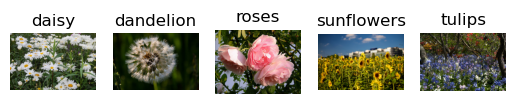

In [46]:
for i,c in enumerate(classes):
    imgs = list((DATA_DIR / c).glob("*.*"))
    if not imgs:
        continue
    p = random.choice(imgs)
    img = Image.open(p).convert("RGB")
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(c)
plt.show()

## A3) make_subset function

In [47]:
def make_subset(src_dir, dst_dir, per_class=100, seed=42, overwrite=False):
    random.seed(seed)
    src_dir = Path(src_dir)
    dst_dir = Path(dst_dir)
    if dst_dir.exists() and overwrite:
        shutil.rmtree(dst_dir)
    dst_dir.mkdir(parents=True, exist_ok=True)
    classes = [p for p in sorted(src_dir.iterdir()) if p.is_dir()]
    for c in classes:
        src_class_dir = src_dir / c.name
        dst_class_dir = dst_dir / c.name
        dst_class_dir.mkdir(parents=True, exist_ok=True)
        imgs = [p for p in src_class_dir.glob("*.*") if p.suffix.lower() in [".jpg",".jpeg",".png"]]
        if len(imgs) < per_class:
            print(f"Warning: class {c.name} has only {len(imgs)} images (<{per_class})")
        chosen = random.sample(imgs, min(per_class, len(imgs)))
        for p in chosen:
            shutil.copy(p, dst_class_dir / p.name)
    # Print verification
    total = sum(len(list((dst_dir / c.name).glob("*.*"))) for c in classes)
    print(f"Created subset at {dst_dir} with {len(classes)} classes and {total} images")
    return dst_dir

## A4) create subset_200 with 200 images per class

In [48]:
subset200 = make_subset(DATA_DIR, Path("subset_200"), per_class=200, seed=42)

Created subset at subset_200 with 5 classes and 1000 images


## Part B — Data Loading and Augmentation

This cell:
1. Load the subset (e.g., subset_100) from disk using image_dataset_from_directory() and split it into train (80%) and validation (20%) using validation_split.
2. Create a data augmentation pipeline using tf.keras.Sequential() that includes RandomFlip, RandomRotation, and RandomZoom. Visualize 5 augmented versions of a single flower image.

In [49]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)
AUTOTUNE = tf.data.AUTOTUNE
SUBSET_DIR = Path("subset_200")

## B1) Load with train/validation split

In [50]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    SUBSET_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1000 files belonging to 5 classes.
Using 800 files for training.


In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    SUBSET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1000 files belonging to 5 classes.
Using 200 files for validation.


In [52]:
class_names = train_ds.class_names

In [53]:
print("Classes:", class_names)

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [54]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## B2) Data augmentation pipeline

In [55]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
], name="data_augmentation")

In [56]:
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

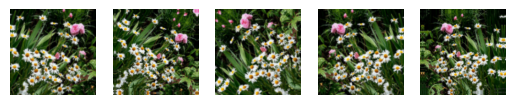

In [57]:
for images, labels in train_ds.take(1):
    img = images[0]
    for i in range(5):
        augmented = data_augmentation(tf.expand_dims(img,0), training=True)
        ax = plt.subplot(1,5,i+1)
        plt.imshow(tf.cast(augmented[0], tf.uint8).numpy())
        plt.axis('off')
plt.show()

## Part C — Model Development (Scratch CNN)
This cell:
1. Build a simple CNN from scratch with 3 convolutional blocks, Flatten, Dense(128, ReLU), and Dense(5, softmax). Print the model summary.
2. Compile the model using optimizer='adam', loss='categorical_crossentropy', and metrics=['accuracy'].
3. Train the model for 20-40 epochs and plot training vs validation accuracy.

## C1) Build a simple CNN

In [58]:
def build_scratch_cnn(input_shape=IMG_SIZE+(3,), num_classes=5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name="scratch_cnn")
    return model

In [59]:
scratch_model = build_scratch_cnn()

In [60]:
scratch_model.summary()

Model: "scratch_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,621 (25.36 MB)

 Trainable params: 6,647,621 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

## C2) Compile

In [61]:
scratch_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

## C3) Train for 20 epochs and plot training vs validation accuracy and training vs validation loss

In [62]:
EPOCHS = 20

In [63]:
history_scratch = scratch_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.2525 - loss: 1.6717 - val_accuracy: 0.3550 - val_loss: 1.4311
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.4425 - loss: 1.2782 - val_accuracy: 0.5350 - val_loss: 1.1609
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step - accuracy: 0.5337 - loss: 1.0885 - val_accuracy: 0.5600 - val_loss: 1.1241
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 512ms/step - accuracy: 0.6325 - loss: 0.9360 - val_accuracy: 0.5800 - val_loss: 1.0855
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 619ms/step - accuracy: 0.7237 - loss: 0.7950 - val_accuracy: 0.5950 - val_loss: 1.1642
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 569ms/step - accuracy: 0.7925 - loss: 0.6148 - val_accuracy: 0.5700 - val_loss: 1.5140
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 593ms/step - accuracy: 0.8238 - loss: 0.4967 - val_accuracy: 0.5950 - val_loss: 1.4976
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 506ms/step - accuracy: 0.8662 - loss: 0.4347 - val_accu

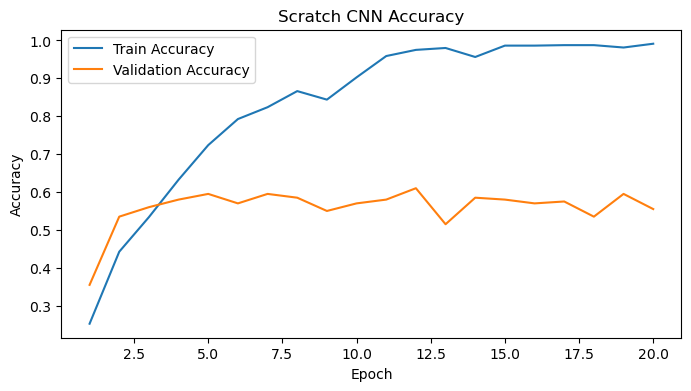

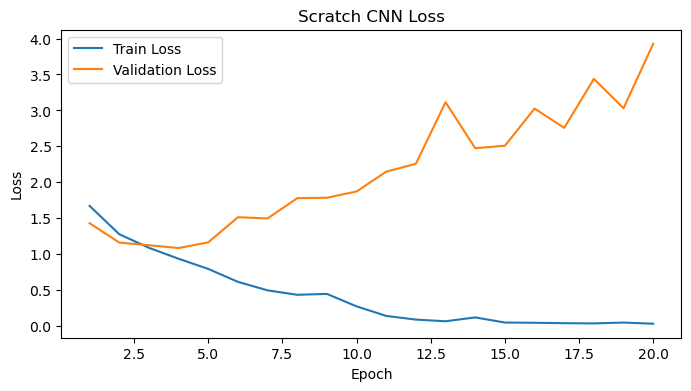

In [64]:
acc = history_scratch.history['accuracy']
val_acc = history_scratch.history['val_accuracy']
loss = history_scratch.history['loss']
val_loss = history_scratch.history['val_loss']

epochs_range = range(1, len(acc)+1)
plt.figure(figsize=(8,4))
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Scratch CNN Accuracy')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Scratch CNN Loss')
plt.show()

## Part D — Transfer Learning (MobileNetV2)
This cell:
1. Use a pretrained MobileNetV2/ResNet50 as a frozen base (weights='imagenet', include_top=False) and train only the new classification head.
2. Fine-tune the top 20 layers of the MobileNetV2 backbone and compare accuracy with the frozen version.
3. Create another subset (e.g., 50 or 200 images per class) and repeat the experiment to observe how dataset size affects performance.

In [65]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


## D1) Build head

In [66]:
inputs = layers.Input(shape=IMG_SHAPE)

In [67]:
x = data_augmentation(inputs)

## D2) MobileNetV2 expects inputs in [-1,1]

In [68]:
x = layers.Rescaling(1./127.5)(x)

In [69]:
x = layers.Rescaling(0.5, offset=-1)(x)

In [70]:
x = base_model(x, training=False)

In [71]:
x = layers.GlobalAveragePooling2D()(x)

In [72]:
x = layers.Dropout(0.2)(x)

In [73]:
outputs = layers.Dense(len(class_names), activation='softmax')(x)

In [74]:
model_tl = Model(inputs, outputs)

In [75]:
model_tl.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [76]:
model_tl.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## D3) Train the frozen model head

In [77]:
EPOCHS = 20

In [78]:
history_frozen = model_tl.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 596ms/step - accuracy: 0.3725 - loss: 1.5811 - val_accuracy: 0.6950 - val_loss: 0.7809
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 570ms/step - accuracy: 0.7000 - loss: 0.8214 - val_accuracy: 0.8200 - val_loss: 0.5362
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - accuracy: 0.7638 - loss: 0.6286 - val_accuracy: 0.8600 - val_loss: 0.4416
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - accuracy: 0.8150 - loss: 0.5252 - val_accuracy: 0.8650 - val_loss: 0.3989
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step - accuracy: 0.8500 - loss: 0.4441 - val_accuracy: 0.8600 - val_loss: 0.3775
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - accuracy: 0.8562 - loss: 0.4176 - val_accuracy: 0.8750 - val_loss: 0.3563
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - accuracy: 0.8925 - loss: 0.3705 - val_accuracy: 0.8800 - val_loss: 0.3433
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 630ms/step - accuracy: 0.8788 - loss: 0.3486 - val_accu

## D4) Fine-tune: unfreeze top 20 layers of base_model

In [79]:
base_model.trainable = True

## D5) Freeze all layers except the top 20

In [80]:
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [81]:
model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [82]:
EPOCHS_FINE = 20

In [83]:
history_finetune = model_tl.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 744ms/step - accuracy: 0.8087 - loss: 0.4835 - val_accuracy: 0.9050 - val_loss: 0.2662
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 491ms/step - accuracy: 0.8612 - loss: 0.3976 - val_accuracy: 0.9100 - val_loss: 0.2614
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 502ms/step - accuracy: 0.8687 - loss: 0.3797 - val_accuracy: 0.9100 - val_loss: 0.2609
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.8850 - loss: 0.3348 - val_accuracy: 0.9100 - val_loss: 0.2586
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 542ms/step - accuracy: 0.9025 - loss: 0.3112 - val_accuracy: 0.9050 - val_loss: 0.2548
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 0.9100 - loss: 0.2681 - val_accuracy: 0.9050 - val_loss: 0.2540
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 520ms/step - accuracy: 0.9187 - loss: 0.2680 - val_accuracy: 0.9050 - val_loss: 0.2553
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 525ms/step - accuracy: 0.9013 - loss: 0.2753 - val_accu

## D6) Plots

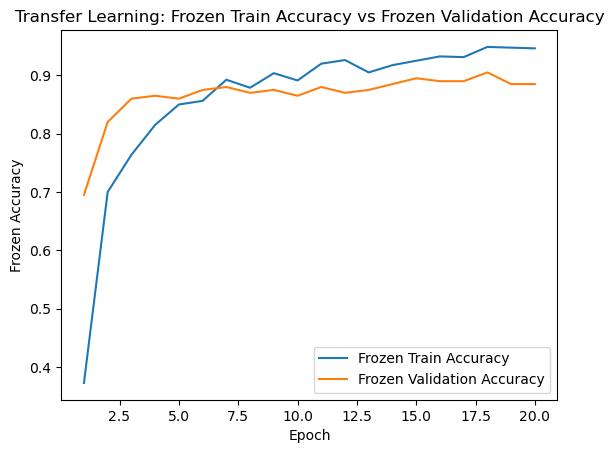

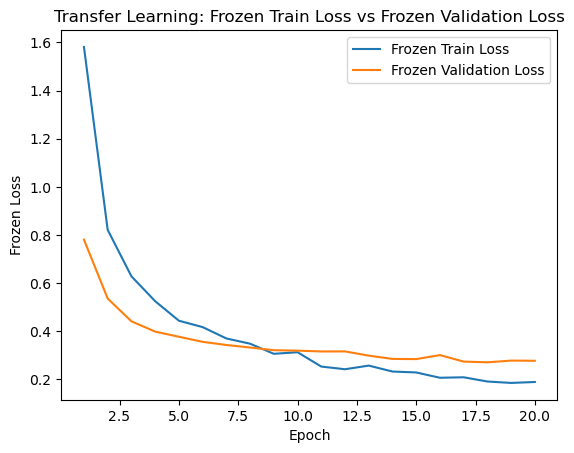

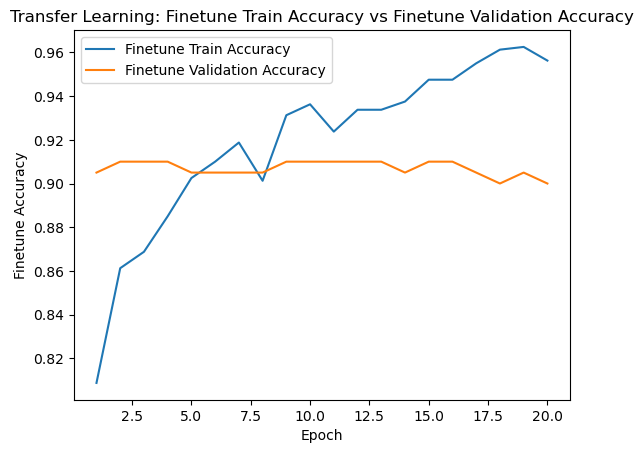

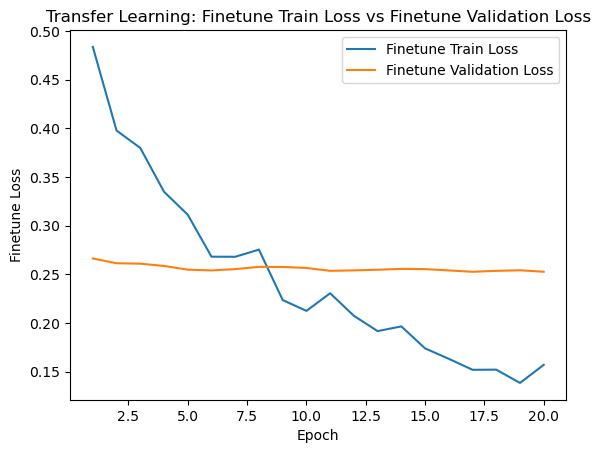

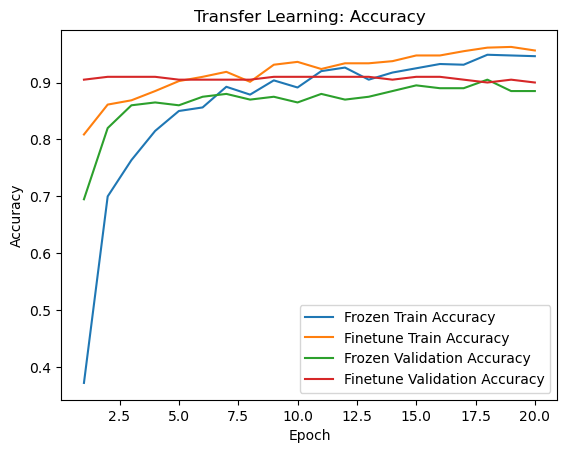

In [88]:
acc_t1 = history_frozen.history['accuracy']
acc_t2 = history_finetune.history['accuracy']
acc_v1 = history_frozen.history['val_accuracy']
acc_v2 = history_finetune.history['val_accuracy']

loss_t1 = history_frozen.history['loss']
loss_t2 = history_finetune.history['loss']
loss_v1 = history_frozen.history['val_loss']
loss_v2 = history_finetune.history['val_loss']

plt.plot(range(1,len(acc_t1)+1), acc_t1, label='Frozen Train Accuracy')
plt.plot(range(1,len(acc_v1)+1), acc_v1, label='Frozen Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Frozen Accuracy')
plt.title('Transfer Learning: Frozen Train Accuracy vs Frozen Validation Accuracy')
plt.show()

plt.plot(range(1,len(loss_t1)+1), loss_t1, label='Frozen Train Loss')
plt.plot(range(1,len(loss_v1)+1), loss_v1, label='Frozen Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Frozen Loss')
plt.title('Transfer Learning: Frozen Train Loss vs Frozen Validation Loss')
plt.show()

plt.plot(range(1,len(acc_t2)+1), acc_t2, label='Finetune Train Accuracy')
plt.plot(range(1,len(acc_v2)+1), acc_v2, label='Finetune Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Finetune Accuracy')
plt.title('Transfer Learning: Finetune Train Accuracy vs Finetune Validation Accuracy')
plt.show()

plt.plot(range(1,len(loss_t2)+1), loss_t2, label='Finetune Train Loss')
plt.plot(range(1,len(loss_v2)+1), loss_v2, label='Finetune Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Finetune Loss')
plt.title('Transfer Learning: Finetune Train Loss vs Finetune Validation Loss')
plt.show()

plt.plot(range(1,len(acc_t1)+1), acc_t1, label='Frozen Train Accuracy')
plt.plot(range(1,len(acc_t2)+1), acc_t2, label='Finetune Train Accuracy')
plt.plot(range(1,len(acc_v1)+1), acc_v1, label='Frozen Validation Accuracy')
plt.plot(range(1,len(acc_v2)+1), acc_v2, label='Finetune Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transfer Learning: Accuracy')
plt.show()

## Part E — Evaluation & Reporting

This cell:
1. For each experiment (subset size × method), record Training Accuracy, Validation Accuracy, and Model Size (in MB).
2. Plot Validation Accuracy vs. Subset Size for Scratch, Transfer (frozen), and Transfer (fine-tuned) models.
3. Generate a confusion matrix and classification report for the best-performing model.
4. Save the best model as best_flower_model.keras and write a small program to predict the class of a new flower image loaded from disk.

## E1) Record final accuracies and model sizes

In [89]:
def get_final_metrics(history, model):
    final_train_acc = history.history.get('accuracy', [None])[-1]
    final_val_acc = history.history.get('val_accuracy', [None])[-1]
    # model size (approx) - save temporarily
    tmp_path = "tmp_save.keras"
    model.save(tmp_path, include_optimizer=False)
    size_mb = os.path.getsize(tmp_path) / (1024*1024)
    try:
        os.remove(tmp_path)
    except:
        pass
    return final_train_acc, final_val_acc, size_mb

In [90]:
metrics_scratch = get_final_metrics(history_scratch, scratch_model)
print("Scratch model metrics (train_acc, val_acc, size_mb):", metrics_scratch)

Scratch model metrics (train_acc, val_acc, size_mb): (0.9912499785423279, 0.5550000071525574, 76.12495040893555)


In [91]:
metrics_frozen = get_final_metrics(history_frozen, model_tl)
print("Transfer frozen metrics (train_acc, val_acc, size_mb):", metrics_frozen)

Transfer frozen metrics (train_acc, val_acc, size_mb): (0.9462500214576721, 0.8849999904632568, 18.4788236618042)


In [92]:
metrics_finetune = get_final_metrics(history_finetune, model_tl)
print("Transfer finetune metrics (train_acc, val_acc, size_mb):", metrics_finetune)

Transfer finetune metrics (train_acc, val_acc, size_mb): (0.956250011920929, 0.8999999761581421, 18.4788236618042)


## E2) Confusion matrix and classification report for the best model (choose model_tl as example)

In [93]:
y_true = []
y_pred = []

In [94]:
for images, labels in val_ds:
    preds = model_tl.predict(images)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [95]:
cm = confusion_matrix(y_true, y_pred)

In [96]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[36  3  1  1  0]
 [ 0 37  0  1  0]
 [ 1  0 41  0  2]
 [ 1  1  2 39  0]
 [ 0  0  6  1 27]]


In [97]:
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
               precision    recall  f1-score   support

       daisy       0.95      0.88      0.91        41
   dandelion       0.90      0.97      0.94        38
       roses       0.82      0.93      0.87        44
  sunflowers       0.93      0.91      0.92        43
      tulips       0.93      0.79      0.86        34

    accuracy                           0.90       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



## E3) Save best model and small predict function

In [98]:
BEST_PATH = "best_flower_model.keras"

In [99]:
model_tl.save(BEST_PATH)

In [100]:
print(f"Saved best model to {BEST_PATH} (size: {os.path.getsize(BEST_PATH)/(1024*1024):.2f} MB)")

Saved best model to best_flower_model.keras (size: 18.48 MB)
